# Car Price Prediction Hackathon by MachineHack

***Notebook Author:***

| **Name:**|Pradip Kumar Das |
|--:|--|
|**Profile:**| [LinkedIn](https://www.linkedin.com/in/daspradipkumar/ "LinkedIn") \| [GitHub](https://github.com/PradipKumarDas "GitHub") \| [Kaggle](https://www.kaggle.com/pradipkumardas "Kaggle")|
|**Contact:**| pradipkumardas@hotmail.com (Email), +91 8050003133 (Mobile) |
|**Location:**|Bengaluru, Karnataka, India|

**_Sections:_**
- _Dependencies_
- _Configuration_
- _Exploratory Data Analysis (EDA) & Preprocessing_
- _Modeling & Evaluation_
- _Submission_

## Dependencies

In [1]:
# Imports required packages

import pandas as pd
import numpy as np
import random

from catboost import CatBoostRegressor, Pool, cv

import matplotlib.pyplot as plt
import seaborn as sns

## Configuration

In [2]:
# Seed to reproduce the results
random.seed(42)
np.random.seed(42)

# Sets option to view all columns in DataFrame
pd.set_option("display.max_columns", None) 

## Exploratory Data Analysis (EDA) & Preprocessing

In [60]:
# Loads data

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [61]:
# Checks for dataset shapes

print(f"Dataset shape:\ttrain: {train.shape}\ttest: {test.shape}")

Dataset shape:	train: (19237, 18)	test: (8245, 18)


In [62]:
# Checks for heads of the datasets

display(train.head())

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [63]:
# Merges both Manufacturer and Model into one

train["Model"] = train.Manufacturer + " " + train.Model

In [64]:
# Drops column ID considering not required for modeling

train.drop(["ID"], axis=1, inplace=True)

In [65]:
# Checks for duplicate rows in the dataset

train.duplicated(keep=False).sum()

4927

In [66]:
# Drops all duplicates

train.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [67]:
# Checks for the data types for train dataset

display(train.dtypes)

Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object

In [68]:
# Converts all text into lowercase

train = pd.concat(
    [train[col].str.lower() if train[col].dtype == 'object' else train[col] for col in train.columns ], 
    axis=1)

In [69]:
# Extracts only numeric value for column Engine volume

train[["Engine volume", "Turbo"]] = train["Engine volume"].str.split(expand=True)
train["Engine volume"] = train["Engine volume"].astype("float")

# Keeps the information whether the engine is Turbo charged or not

train["Turbo"].fillna("no", inplace=True)
train["Turbo"].replace("turbo", "yes", inplace=True)

In [71]:
# Gets the Engine volume statistics

train["Engine volume"].describe()

count    15725.000000
mean         2.212820
std          0.806187
min          0.000000
25%          1.700000
50%          2.000000
75%          2.500000
max         20.000000
Name: Engine volume, dtype: float64

<AxesSubplot:xlabel='Engine volume', ylabel='Count'>

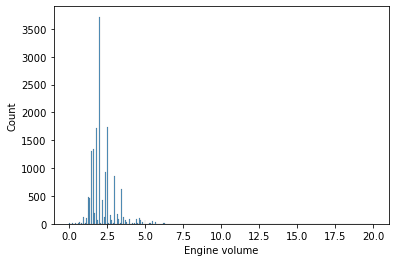

In [72]:
# Plots the overall distribution of Engine volume

sns.histplot(train["Engine volume"])

<AxesSubplot:xlabel='Engine volume', ylabel='Count'>

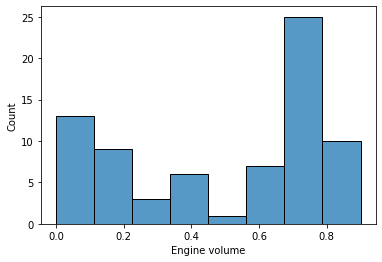

In [73]:
# Plots the distribution of small engines

sns.histplot(train["Engine volume"][train["Engine volume"] < 1.0])

In [74]:
# Filter outs rows with Engine volume considered to be outliers

train = train[(train["Engine volume"] >= 0.4) & (train["Engine volume"] <= 8.0)]

In [75]:
# Seperates Mileage from its units to get its numeric value

train["Mileage"] = train["Mileage"].str.split(expand=True)[0]
train["Mileage"] = train["Mileage"].astype("int")

/home/pradip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/pradip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='Price'>

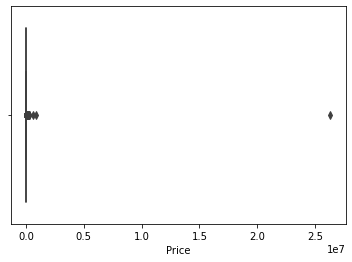

In [76]:
# Plots the overall distribution of price

sns.boxplot(x=train.Price)

<AxesSubplot:xlabel='Price'>

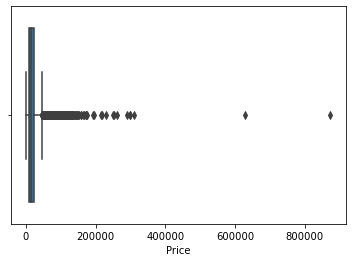

In [77]:
# Plots the price further without visible outliers

sns.boxplot(x=train.Price[train.Price < 2.5e7])

In [78]:
# Filters outs rows with price considered outliers

train = train[train.Price <= 400000]

## Modeling & Evaluation

In [79]:
# Tags price with bin for equal distribution of price of different range

train["bin"] = pd.cut(train.Price, bins=10, labels=list(range(10)))

In [80]:
# Stores column names for all features to be used for modeling

features = ["Model", "Prod. year", "Category", "Leather interior", "Fuel type", "Engine volume", \
            "Mileage", "Gear box type", "Drive wheels", "Airbags", "Turbo"]

In [81]:
# Stores indices of categorical features to be passed in while training model

categorical_features_indices = [0, 2, 3, 4, 7, 8, 10]

**CatBoost**

In [82]:
# Changing categorical variables datatypes to make CatBoost compatible

X_train = train[features].astype({'Model': 'string', 'Category': 'string', 'Leather interior': 'string', "Fuel type": 'string', \
                       'Gear box type': 'string', 'Drive wheels': 'string', 'Turbo': 'string'})

In [83]:
X_train.dtypes

Model                string
Prod. year            int64
Category             string
Leather interior     string
Fuel type            string
Engine volume       float64
Mileage               int64
Gear box type        string
Drive wheels         string
Airbags               int64
Turbo                string
dtype: object

In [84]:
# Create internal structure specific to CatBoost to handle training data

cv_pool = Pool(X_train.values, train.Price, cat_features=categorical_features_indices)

In [85]:
# CatBoost performs training over cross-validation

cv_scores = cv(cv_pool, params={
    "loss_function": "RMSE", 
    "verbose": False}, fold_count=5, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [86]:
# Create internal structure specific to CatBoost to handle training data

train_pool = Pool(X_train.values, train.Price, cat_features=categorical_features_indices)

In [87]:
# Performs model training

model = CatBoostRegressor(random_seed=42, loss_function="RMSE")
model.fit(train_pool, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [88]:
# Checks for feature importance according to CatBoost

model.feature_importances_

array([ 7.26460685, 25.84661316,  4.49933   ,  1.80806548,  3.9924351 ,
       15.69790649,  5.86083806, 11.31756933,  3.38738827, 13.98991333,
        6.33533394])

## Submission

In [89]:
# Merges both Manufacturer and Model into one

test["Model"] = test.Manufacturer + " " + test.Model

In [90]:
# Drops column ID considering not required for modeling

test.drop(["ID"], axis=1, inplace=True)

In [91]:
# Checks for the data types for train dataset

test.dtypes

Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders             int64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
Price               float64
dtype: object

In [92]:
# Converts all text into lowercase

test = pd.concat(
    [test[col].str.lower() if test[col].dtype == 'object' else test[col] for col in test.columns ], 
    axis=1)

In [93]:
# Extracts only numeric value for column Engine volume

test[["Engine volume", "Turbo"]] = test["Engine volume"].str.split(expand=True)
test["Engine volume"] = test["Engine volume"].astype("float")

# Keeps the information whether the engine is Turbo charged or not

test["Turbo"].fillna("no", inplace=True)
test["Turbo"].replace("turbo", "yes", inplace=True)

In [94]:
# Seperates Mileage from its units to get its numeric value

test["Mileage"] = test["Mileage"].str.split(expand=True)[0]
test["Mileage"] = test["Mileage"].astype("int")

In [97]:
# Changing categorical variables datatypes to make CatBoost compatible

X_test = test[features].astype({'Model': 'string', 'Category': 'string', 'Leather interior': 'string', "Fuel type": 'string', \
                       'Gear box type': 'string', 'Drive wheels': 'string', 'Turbo': 'string'})

In [101]:
# Create internal structure specific to CatBoost to handle training data

test_pool = Pool(X_test.values, cat_features=categorical_features_indices)

In [102]:
# Performs predictions

predictions = model.predict(test_pool)

In [103]:
# Checks the predictions statistics

pd.Series(predictions).describe()

count      8245.000000
mean      17324.136829
std       14431.158804
min       -3071.749317
25%        7801.174456
50%       13766.417028
75%       21486.932616
max      164696.949025
dtype: float64

In [104]:
# Clips prediction values if goes negative

predictions = np.clip(predictions, 0, None)

In [105]:
# Saves prediction into .CSV file

predictions = pd.DataFrame(predictions, columns=["Price"], dtype='int') 
predictions.to_csv("./submission.csv", index=False)